### Importing Libraries

In [1]:
import numpy as np
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.datasets import make_moons, make_blobs
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
!pip install kneed
from kneed import KneeLocator
import pandas as pd
from sklearn.decomposition import PCA
import warnings
warnings.filterwarnings("ignore", category=FutureWarning, module="sklearn.cluster._kmeans")
warnings.filterwarnings("ignore", category=UserWarning, module="sklearn.cluster._kmeans")

### Importing The Datasets 

#### Dataset 1

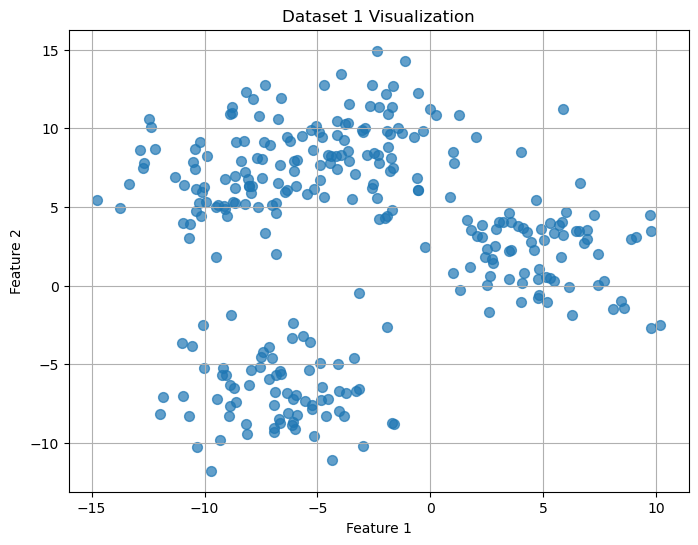

In [34]:
# Random seed
np.random.seed(42)

# Creating the dataset
data1, _ = make_blobs(n_samples=300, n_features=2, centers=4, cluster_std=2.4, random_state=42)

# Plotting the dataset
plt.figure(figsize=(8, 6))
plt.scatter(data1[:, 0], data1[:, 1], marker='o', s=50, alpha=0.7)
plt.title('Dataset 1 Visualization')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.grid(True)
plt.show()

#### Dataset 2

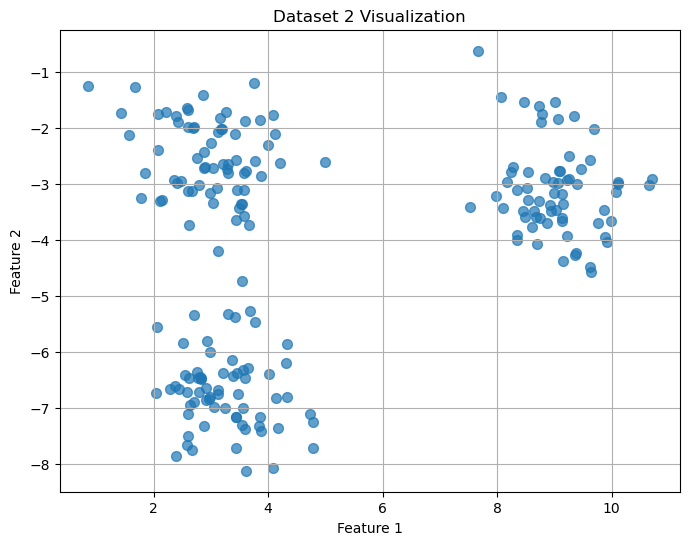

In [6]:
# Set random seed
np.random.seed(30)

# Creating the dataset
data2, _ = make_blobs(n_samples=200, n_features=2, centers=3, cluster_std=0.7, random_state=30)

# Plotting the dataset
plt.figure(figsize=(8, 6))
plt.scatter(data2[:, 0], data2[:, 1], marker='o', s=50, alpha=0.7)
plt.title('Dataset 2 Visualization')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.grid(True)
plt.show()

#### Dataset 3

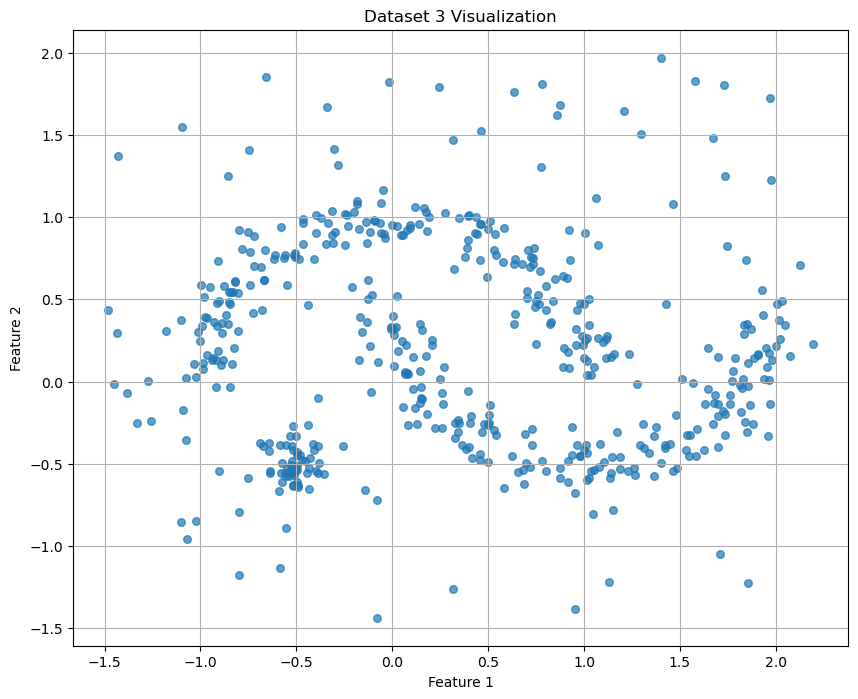

In [7]:
# Set random seed
np.random.seed(214)

# Creating the dataset
X_moons, _ = make_moons(n_samples=350, noise=0.1, random_state=214)
X_blobs, _ = make_blobs(n_samples=50, centers=[[-0.5,-0.5]], cluster_std=[0.1], random_state=214)
X_noise = np.random.uniform(low=-1.5, high=2.0, size=(100,2))

data3 = np.vstack([X_moons, X_blobs, X_noise])

# Plotting the dataset
plt.figure(figsize=(10, 8))
plt.scatter(data3[:, 0], data3[:, 1], marker='o', s=30, alpha=0.7)
plt.title('Dataset 3 Visualization')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.grid(True)
plt.show()

#### Dataset 4

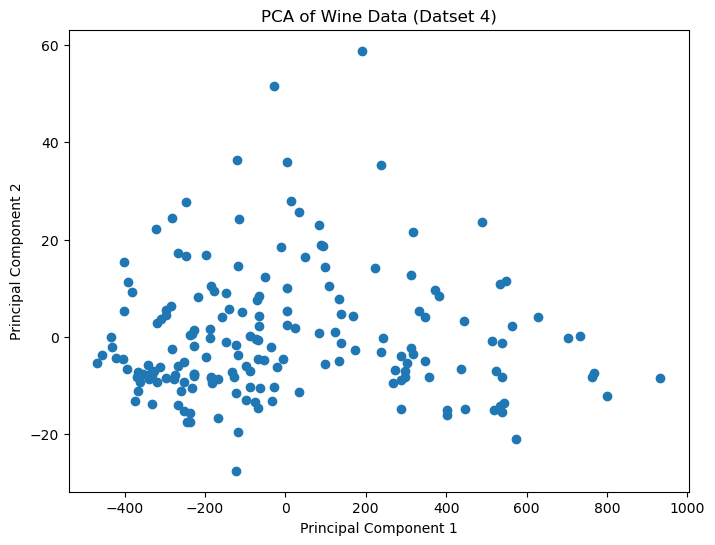

In [41]:
# Loading Dataset
wine_data = pd.read_csv("C:\\Users\\Jordy\\Downloads\\wine-clustering.csv")

# PCA for  visualization
pca = PCA(n_components=2)
wine_data_transformed = pca.fit_transform(wine_data)

# Plotting the dataset
plt.figure(figsize=(8, 6))
plt.scatter(wine_data_transformed[:, 0], wine_data_transformed[:, 1])
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA of Wine Data (Datset 4)')
plt.show()

### Building the function

In [42]:
def ensemble_cluster(data, starting_k=2, max_iterations=10, kmeans_runs=10):
    last_score = 0
    best_iteration = 0
    kmeans_clusters_new = starting_k

    best_kmeans_score = -1
    best_dbscan_score = -1
    best_kmeans = None
    dbscan_best = None

    for i in range(max_iterations):
        best_inertia = np.inf

        # Run K-means multiple times for the current number of clusters, choose the one with the best inertia
        for _ in range(kmeans_runs):
            kmeans = KMeans(n_clusters=kmeans_clusters_new, init='random', n_init=1).fit(data)
            if kmeans.inertia_ < best_inertia:
                best_inertia = kmeans.inertia_
                best_kmeans = kmeans

        # Use the centroids from the best K-means run
        cluster_center = best_kmeans.cluster_centers_

        # Estimate DBSCAN parameters from K-means
        eps = np.mean([np.linalg.norm(cluster_center[i] - cluster_center[j]) for i in range(len(cluster_center)) for j in range(i+1, len(cluster_center))]) / 2
        minPts = len(data) // (kmeans_clusters_new * 2) 

        # DBSCAN clustering run with estimated eps
        dbscan = DBSCAN(eps=eps, min_samples=minPts).fit(data)
        dbscan_labels = dbscan.labels_

        # If DBSCAN finds no clusters (all points labeled -1)
        if len(set(dbscan_labels)) <= 1:
            break

        # Silhouette score 
        score = silhouette_score(data, dbscan_labels)

        # Storing best DBSCAN model based on silhouette score
        if score > last_score:
            last_score = score
            best_iteration = i
            dbscan_best = dbscan
            best_dbscan_score = score  

        # Adjust the number of K-means clusters for the next iteration
        num_dbscan_clusters = len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)
        if num_dbscan_clusters >= kmeans_clusters_new:
            kmeans_clusters_new = num_dbscan_clusters
        else:
            kmeans_clusters_new += 1

    # Silhouette score for the best K-means model
    if best_kmeans is not None:
        kmeans_labels = best_kmeans.predict(data)
        best_kmeans_score = silhouette_score(data, kmeans_labels)

    return best_kmeans, best_kmeans_score, dbscan_best, best_dbscan_score, best_iteration, eps, minPts

### Dataset 1 Run

In [43]:
# Calling our function for dataset 1
best_kmeans, best_kmeans_score, dbscan_best, best_dbscan_score, best_iteration, eps, minPts = ensemble_cluster(data1, starting_k=2, max_iterations=30, kmeans_runs=25)

# Results
print("Best K-means Model:\n", best_kmeans)
print("Silhouette Score of Best K-means Model:", best_kmeans_score)
print("Best DBSCAN Model:\n", dbscan_best)
print("Silhouette Score of Best DBSCAN Model:", best_dbscan_score)
print("Best Iteration:", best_iteration)

Best K-means Model:
 KMeans(init='random', n_clusters=2, n_init=1)
Silhouette Score of Best K-means Model: 0.4929816611422993
Best DBSCAN Model:
 DBSCAN(eps=6.772061564201892, min_samples=75)
Silhouette Score of Best DBSCAN Model: 0.32434161263708694
Best Iteration: 0


#### Visualizing Results

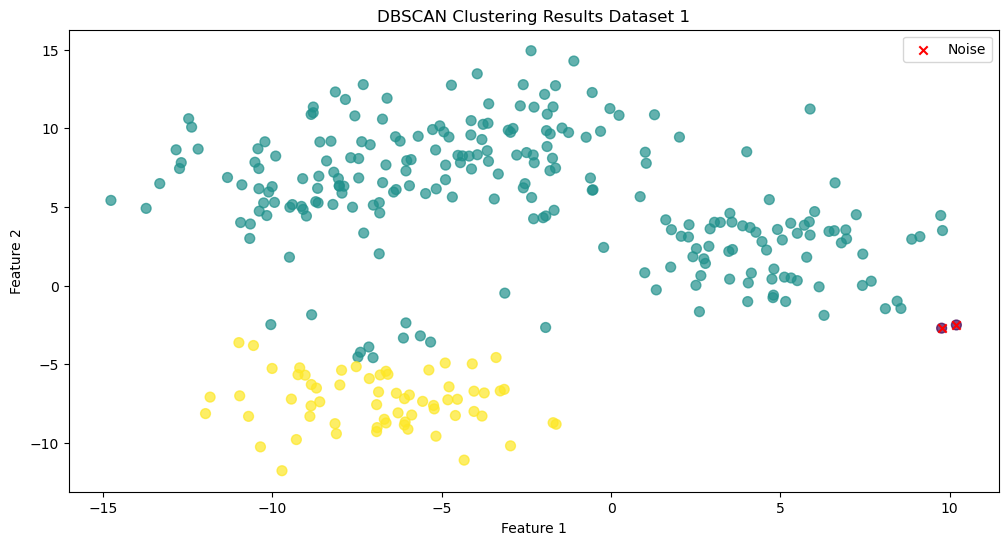

In [44]:
kmeans_labels = best_kmeans.labels_
dbscan_labels = dbscan_best.labels_

plt.figure(figsize=(12, 6))  
plt.scatter(data1[:, 0], data1[:, 1], c=dbscan_labels, cmap='viridis', marker='o', s=50, alpha=0.7)

# Noise
plt.scatter(data1[dbscan_labels == -1, 0], data1[dbscan_labels == -1, 1], color='red', marker='x', label='Noise')

plt.title('DBSCAN Clustering Results Dataset 1')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()  
plt.show() 

### Dataset 2 Run

In [45]:
best_kmeans, best_kmeans_score, dbscan_best, best_dbscan_score, best_iteration, eps, minPts = ensemble_cluster(data2, starting_k=2, max_iterations=15, kmeans_runs=25)

# Results
print("Best K-means Model:\n", best_kmeans)
print("Silhouette Score of Best K-means Model:", best_kmeans_score)
print("Best DBSCAN Model:\n", dbscan_best)
print("Silhouette Score of Best DBSCAN Model:", best_dbscan_score)
print("Best Iteration:", best_iteration)

Best K-means Model:
 KMeans(init='random', n_clusters=2, n_init=1)
Silhouette Score of Best K-means Model: 0.6475412555228118
Best DBSCAN Model:
 None
Silhouette Score of Best DBSCAN Model: -1
Best Iteration: 0


### Dataset 3 Run

In [46]:
best_kmeans, best_kmeans_score, dbscan_best, best_dbscan_score, best_iteration, eps, minPts = ensemble_cluster(data3, starting_k=2, max_iterations=15, kmeans_runs=25)

# Results
print("Best K-means Model:\n", best_kmeans)
print("Silhouette Score of Best K-means Model:", best_kmeans_score)
print("Best DBSCAN Model:\n", dbscan_best)
print("Silhouette Score of Best DBSCAN Model:", best_dbscan_score)
print("Best Iteration:", best_iteration)

Best K-means Model:
 KMeans(init='random', n_clusters=13, n_init=1)
Silhouette Score of Best K-means Model: 0.46350765366676966
Best DBSCAN Model:
 DBSCAN(eps=0.7580322218862545, min_samples=20)
Silhouette Score of Best DBSCAN Model: 0.3596146615837399
Best Iteration: 10


#### Visualization Dataset 3

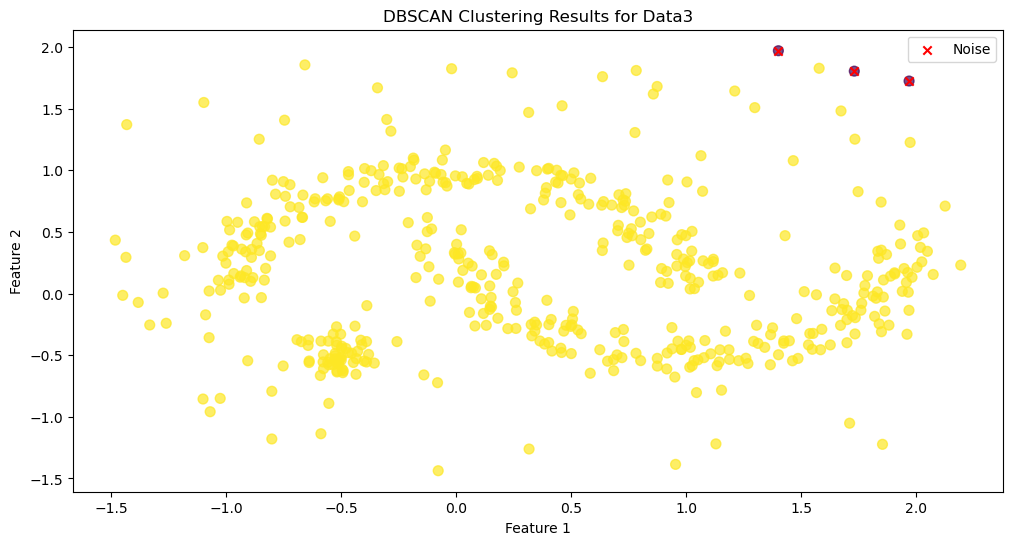

In [47]:
dbscan_labels = dbscan_best.labels_



plt.figure(figsize=(12, 6))  
plt.scatter(data3[:, 0], data3[:, 1], c=dbscan_labels, cmap='viridis', marker='o', s=50, alpha=0.7)

# Noise
plt.scatter(data3[dbscan_labels == -1, 0], data3[dbscan_labels == -1, 1], color='red', marker='x', label='Noise')

plt.title('DBSCAN Clustering Results for Data3')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()  
plt.show()  

### Dataset 4 Run

In [48]:
best_kmeans, best_kmeans_score, dbscan_best, best_dbscan_score, best_iteration, eps, minPts = ensemble_cluster(wine_data, starting_k=2, max_iterations=15, kmeans_runs=25)

# Results
print("Best K-means Model:\n", best_kmeans)
print("Silhouette Score of Best K-means Model:", best_kmeans_score)
print("Best DBSCAN Model:\n", dbscan_best)
print("Silhouette Score of Best DBSCAN Model:", best_dbscan_score)
print("Best Iteration:", best_iteration)

Best K-means Model:
 KMeans(init='random', n_clusters=5, n_init=1)
Silhouette Score of Best K-means Model: 0.5489993239795681
Best DBSCAN Model:
 DBSCAN(eps=292.97271672449506, min_samples=44)
Silhouette Score of Best DBSCAN Model: 0.5393938960075036
Best Iteration: 0


#### Visualization Dataset 4

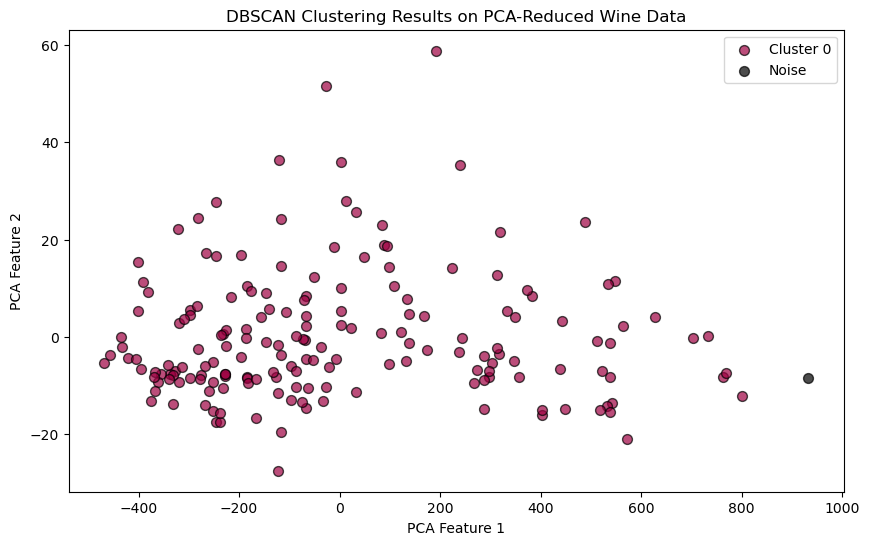

In [54]:
pca = PCA(n_components=2)
wine_data_reduced = pca.fit_transform(wine_data)

# DBSCAN clusters
def plot_dbscan_clusters(data, labels, score):
    plt.figure(figsize=(10, 6))
    unique_labels = set(labels)

   
    colors = plt.cm.Spectral(np.linspace(0, 1, len(unique_labels)))

    # Plotting each cluster
    for label, col in zip(unique_labels, colors):
        if label == -1:
            # Use a dark color for noise.
            col = 'k'

        # Choosing points in the cluster or noise
        cluster_data = data[labels == label]

        plt.scatter(cluster_data[:, 0], cluster_data[:, 1], c=[col], edgecolor='k', s=50, alpha=0.7, label='Cluster {}'.format(label) if label != -1 else 'Noise')

    plt.title(f'DBSCAN Clustering Results on PCA-Reduced Wine Data')
    plt.xlabel('PCA Feature 1')
    plt.ylabel('PCA Feature 2')
    plt.legend()
    plt.show()

# Model Check
if dbscan_best is not None:
    dbscan_labels = dbscan_best.labels_
    plot_dbscan_clusters(wine_data_reduced, dbscan_labels, best_dbscan_score)
else:
    print("No DBSCAN model to visualize.")